 CS 225 / MS&E 236 Final Project 

In [245]:
import numpy as np
import cvxpy as cp
import time
import torch
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, MessagePassing
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
"""
This function below takes as input the necessary parameters for the shift-scheduling problem,
and outputs the decision variables along with the objective and constraints.

Important: We call on this function to solve the LP-relaxed problem during branch-and-bound, so
the scheduling matrix is not defined as binary here
"""
def setup_problem(n,m,w,A,lmin,lmax,p):
    X = cp.Variable((m, n), boolean = True)  # Start of each shift
    S = cp.Variable((m, n), )                # Durations of each shift
    y = cp.Variable(m, boolean = True)       # Whether shift is assigned at all
    d = cp.Variable(n)                       # Work done
    o = cp.Variable(n)                       # Work outstanding

    objective = cp.Minimize(cp.sum(S) - cp.sum(d))

    constraints = []
    for i in range(n):
        # The work done at time i cannot exceed number of workers times productivity:
        constraints += [d[i] <= p * cp.sum(S[:, i])] 
        # The work done also cannot exceed the work to be done at that time 
        constraints += [d[i] <= w[i]]

    # We define the flow between work outstanding, work done and work to be done
    constraints += [o[0] == w[0]]
    for i in range(1, n):
        constraints += [o[i] == o[i-1] - d[i] + w[i]]

    # We constrain the shifts to maximum and minimum lengths
    for i in range(m):
        constraints += [cp.sum(S[i, :]) >= lmin * y[i]]
        constraints += [cp.sum(S[i, :]) <= lmax * y[i]]

    # We allow one start per worker, so they work at most one shift over the duration
    for i in range(m):
        constraints += [X[i, 0] == S[i, 0]]
        for j in range(1, n):
            constraints += [X[i, j] <= S[i, j] - S[i, j-1]]
        constraints += [cp.sum(X[i, :]) <= 1]

    # We only schedule those who are available
    constraints += [S <= A]

    return objective, constraints, X, S, y, d, o


In [3]:
"""
This function finds the optimal solution to the LP-relaxed problem.
"""
def solve_lp(objective, constraints, X, S, y, d, o):
    problem = cp.Problem(objective, constraints)
    problem.solve()  
    return problem, S

In [127]:
"""
This function finds the optimal solution using branch-and-bound.
"""
def branch_and_bound(objective, constraints, X, S, y, d, o):
    
    # Initialize the best solutions, objective values and the stack of problems to solve
    best_obj = float('inf')
    best_sol = None
    best_schedule = None
    stack = [(objective, constraints, X, S, y, d, o)]
    number_of_branches = 0
    t0 = time.time()
    while stack:
        # Check a subproblem in our stack, solve for LP-relaxation
        obj, constr, X, S, y, d, o = stack.pop()
        prob, S_lp = solve_lp(obj, constr, X, S, y, d, o)
        if number_of_branches >= 3000:
            best_sol = None
            best_obj = None
            best_schedule = S_lp
            number_of_branches = float('inf')
            break
            
        if prob.status != cp.OPTIMAL: # If the LP-relaxation is infeasible we skip this subproblem
            continue

        if prob.value >= best_obj: # If we find a worse solution than our previous best, can skip
            continue

        solution = {var.name(): var.value for var in prob.variables()}

        # Check if all decision variables of LP-relaxation are integers
        all_integers = np.all(np.isclose(S_lp.value, S_lp.value.astype(int), atol=1e-3))
        if all_integers: # If so, we have a new best solution
            best_obj = prob.value
            best_sol = solution
            best_schedule = S_lp.value
            continue

        # Find the first fractional variable
        frac_vars = [(i, j) for i in range(m) for j in range(n) if not np.isclose(S_lp.value[i, j], round(S_lp.value[i, j]), atol=1e-3)]

        if not frac_vars: # If there are none, we have a new best solution
            best_obj = prob.value
            best_sol = solution
            best_schedule = S_lp.value
            continue

        i, j = frac_vars[0] # Choose the first fractional variables

        # Create new constraints for branching
        #print("Branching on ", i,j)
        number_of_branches += 1
        new_constr1 = constr + [S[i, j] == 0]
        new_constr2 = constr + [S[i, j] == 1]

        # Add new subproblems to the stack
        stack.append((obj, new_constr1, X, S, y, d, o))
        stack.append((obj, new_constr2, X, S, y, d, o))
    t1 = time.time()
    solve_time = t1 - t0
    return best_sol, best_obj, best_schedule, number_of_branches

In [72]:
"""
This function creates a graph that represents our problem, with nodes for every decision variable
and every constraint, and edges connecting the variables with the corresponding constraints. 
"""
def create_graph_representation(A, w, lmin, lmax, p):
    G = nx.Graph()
    m, n = A.shape 
    
    # Add decision variables - S, X, y, d, o
    for i in range(m):
        for j in range(n):
            G.add_node(f"S_{i}_{j}", label=f"S_{i}_{j}", type="decision")
            G.add_node(f"X_{i}_{j}", label=f"X_{i}_{j}", type="decision")
        G.add_node(f"y_{i}", label=f"y_{i}", type="decision")
        
    for i in range(n):
        G.add_node(f"d_{i}", label=f"d_{i}", type="decision")
        G.add_node(f"o_{i}", label=f"o_{i}", type="decision")
    
    # Add constraints
    # [d[i] <= p * cp.sum(S[:, i]) for i in range(n)] - n constraints
    # equivalently, [d[i] - p*cp.sum(S[:,i) <= 0 for i in range(n)] 
    for j in range(n):
        G.add_node(f"dS_constraint_{j}", label=f"dS_constraint_{j}", type="constraint", rhs=0, constraint_type="le")
        G.add_edge(f"d_{j}", f"dS_constraint_{j}", coefficient=1, label="+1")
        for i in range(m):
            G.add_edge(f"S_{i}_{j}", f"dS_constraint_{j}", coefficient=-p, label="-p")
    
    # [d[i] <= w[i] + o[i] for i in range(n)
    # equivalently, d[i] - o[i] <= w[i] 
    for i in range(n):
        G.add_node(f"dwo_constraint_{i}", label=f"dwo_constraint_{i}", type="constraint", rhs=w[i], constraint_type="le")
        G.add_edge(f"d_{i}", f"dwo_constraint_{i}", coefficient=1, label="+1")
        #G.add_edge(f"o_{i}", f"dwo_constraint_{i}", coefficient=-1, label="-1")
    
    # [o[0] == w[0]]
    G.add_node(f"do0_constraint", label=f"do0_constraint", type="constraint", rhs=w[0])
    G.add_edge(f"o_0", f"do0_constraint", coefficient=1, label="+1", constraint_type="equality")
    
    # [o[i] == o[i-1] - d[i] + w[i]] for i in range(1,n)
    # equivalently, o[i] - o[i-1] + d[i] == w[i]
    for i in range(1,n):
        G.add_node(f"odw_constraint_{i}", label=f"odw_constraint_{i}", type="constraint", rhs=w[i])
        G.add_edge(f"d_{i}", f"odw_constraint_{i}", coefficient=1, label="+1")
        G.add_edge(f"o_{i}", f"odw_constraint_{i}", coefficient=1, label="+1")
        G.add_edge(f"o_{i-1}", f"odw_constraint_{i}", coefficient=-1, label="-1")
    
    # [cp.sum(S[i, :]) >= lmin * y[i]] for i in range m
    # and [cp.sum(S[i, :]) <= lmax * y[i]]
    for i in range(m):
        G.add_node(f"Symin_constraint_{i}", label=f"Symin_constraint_{i}", type="constraint", rhs=0, constraint_type="ge")
        G.add_node(f"Symax_constraint_{i}", label=f"Symax_constraint_{i}", type="constraint", rhs=0, constraint_type="le")
        
        G.add_edge(f"y_{i}", f"Symin_constraint_{i}", coefficient=-lmin, label=f"-{lmin}")
        G.add_edge(f"y_{i}", f"Symax_constraint_{i}", coefficient=-lmax, label=f"-{lmax}")
    
        for j in range(n):
            G.add_edge(f"S_{i}_{j}", f"Symin_constraint_{i}", coefficient=1, label="+1")
            G.add_edge(f"S_{i}_{j}", f"Symax_constraint_{i}", coefficient=1, label="+1")
    
    # [X[i, 0] == S[i, 0]] and [X[i, j] <= S[i, j] - S[i, j-1]] for i in range(m) and j in range(1,n)
    for i in range(m):
        G.add_node(f"XS_constraint_{i}_0", label=f"XS_constraint_{i}_0", type="constraint", rhs=0, constraint_type="eq")
        G.add_edge(f"X_{i}_0", f"XS_constraint_{i}_0", coefficient=1, label="+1")
        G.add_edge(f"S_{i}_0", f"XS_constraint_{i}_0", coefficient=-1, label="-1")
    for i in range(m):
        for j in range(1, n):
            G.add_node(f"XS_diff_constraint_{i}_{j}", label=f"XS_diff_constraint_{i}_{j}", type="constraint", rhs=0, constraint_type="le")
            G.add_edge(f"X_{i}_{j}", f"XS_diff_constraint_{i}_{j}", coefficient=1, label="+1")
            G.add_edge(f"S_{i}_{j}", f"XS_diff_constraint_{i}_{j}", coefficient=-1, label="-1")
            G.add_edge(f"S_{i}_{j-1}", f"XS_diff_constraint_{i}_{j}", coefficient=1, label="+1")
    
    # [cp.sum(X[i, :]) <= 1] for i in range(m):
    for i in range(m):
        G.add_node(f"sumX_constraint_{i}", label=f"sumX_constraint_{i}", type="constraint", rhs=1, constraint_type="le")
        for j in range(n):
            G.add_edge(f"X_{i}_{j}", f"sumX_constraint_{i}", coefficient=1, label="+1")
    
    # [S <= A]
    for i in range(m):
        for j in range(n):
            G.add_node(f"SA_constraint_{i}_{j}", label=f"SA_constraint_{i}_{j}", type="constraint", rhs=A[i, j], constraint_type="le")
            G.add_edge(f"S_{i}_{j}", f"SA_constraint_{i}_{j}", coefficient=1, label="+1")

    return G

In [73]:
"""
This function generates problem instances given the dimensions of our schedule.
The parameters are randomly assigned but this can be changed to reflect specific problem distributions
"""
def generate_problem_instances(num_instances, m, n):
    instances = []
    for _ in range(num_instances):
        w = m * np.random.uniform(0, 5, n)         # Workload over the duration
        if n <= 4:
            lmin = 1
            lmax = n
        else:
            lmin = np.random.randint(2, int(n/2))      # Random minimum number of intervals in a shift
            lmax = np.random.randint(int(n/2), n-2)    # Random minimum number of intervals in a shift
        A = np.ones((m, n))                        # Availability of workers
        A[np.random.randint(0, m), :] = 0          # Randomly set some workers as unavailable
        p = np.random.randint(5, 10)               # Random productivity

        instances.append((w, A, lmin, lmax, p))
    return instances

In [246]:
def visualize_graph(G):
    plt.figure(figsize=(6, 6))
    plt.clf()  # Clear the current figure
    pos = nx.spring_layout(G)  # Use spring layout for better visualization
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')
    
    nx.draw_networkx(G, pos, labels=labels, with_labels=True, node_size=800, node_color="skyblue", edgecolors='black', font_size=5, font_color="black", font_weight="bold", edge_color="gray")
    
    plt.title("Graph Representation of MILP")
    plt.savefig("graph_visualization.png")
    plt.show()

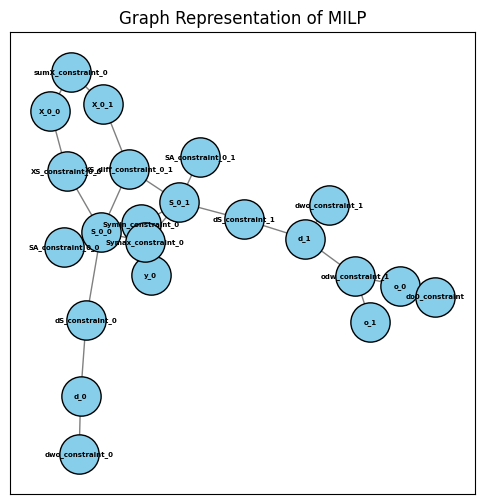

In [154]:
"""
To visualize the graph, let's create a sample problem instance to see the layout and connections.
"""

instance = generate_problem_instances(1, 1, 2)
w, A, lmin, lmax, p = instance[0]
G = create_graph_representation(A, w, lmin, lmax, p)
visualize_graph(G)


In [75]:
"""
We generate labeled data of problem instances and their solutions as found by branch and bound.
"""
def generate_labeled_data(m, n, num_instances):
    # Initialize problem instances and solutions
    solved_instances = []
    solutions = []
    
    instances = generate_problem_instances(num_instances, m, n)
    
    for i in range(len(instances)):
        instance = instances[i]
        #print("Solving instance " + str(i))
        
        # Get the prolem parameters from the problem instance
        w, A, lmin, lmax, p = instance
        
        # Get the decision variables, objective and constraints from parameters
        objective, constraints, X, S, y, d, o = setup_problem(n,m,w,A,lmin,lmax,p)

        # Find optimal solution using branch and bound
        #best_sol, best_obj, best_S = branch_and_bound(objective, constraints, X, S, y, d, o)
        _, best_obj, best_S = solve_cvxpy(n,m,w,A,lmin,lmax,p)

        # Add to our stacks
        solved_instances.append(instance)
        solutions.append(best_S)

    return solved_instances, solutions


In [76]:
"""
For a given graph representing a problem instance and the corresponding solution, we want to create
a Geometric Data object that we can use to train a GNN.
"""
def nx_to_pyg(G, solution):
    # Define node features (binary encoding for decision variable nodes and constraint nodes)
    node_type_map = {"decision": 0, "constraint": 1}
    node_features = []
    node_indices = {node: i for i, node in enumerate(G.nodes())}
    
    for node in G.nodes(data=True):
        node_type = node[1]["type"]
        node_features.append(node_type_map[node_type])
    
    x = torch.tensor(node_features, dtype=torch.float).unsqueeze(1) 
    
    # Edge indices and edge features
    edge_index = []
    edge_attr = []
    
    for edge in G.edges(data=True):
        u, v, attr = edge
        edge_index.append([node_indices[u], node_indices[v]])
        edge_attr.append([attr.get("coefficient", 0)])  
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Define target
    solutions_tensor = torch.tensor(solution.reshape(-1), dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=solutions_tensor)

    return data


In [77]:
"""
We use the functions defined above to create our labeled dataset of problem instances as 
Geometric Data objects with the optimal value of each decision variable node as labels.
"""
def create_data_instance(instance, solution):
    w, A, lmin, lmax, p = instance
    G = create_graph_representation(A, w, lmin, lmax, p)
    data_pyg = nx_to_pyg(G, solution)
    return data_pyg

def create_dataset(solved_instances, solutions):
    dataset = []
    for instance, solution in zip(solved_instances, solutions):
        data = create_data_instance(instance, solution)
        dataset.append(data)
    return dataset

In [247]:
"""
Here we define our GNN, inspired by MIP-GNN [1].
"""

class MIP_GNN(MessagePassing):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MIP_GNN, self).__init__(aggr='add') 
        self.var_to_const = nn.Linear(input_dim, hidden_dim)
        self.const_to_var = nn.Linear(hidden_dim, hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        # Initial variable embeddings (variable nodes to constraint nodes)
        var_embeddings = self.var_to_const(x)
        const_embeddings = self.propagate(edge_index, x=var_embeddings, edge_attr=edge_attr)
        # Constraint embeddings to variable embeddings
        const_embeddings = self.const_to_var(const_embeddings)
        var_embeddings = self.propagate(edge_index.flip([0]), x=const_embeddings, edge_attr=edge_attr)
        pooled_embeddings = global_mean_pool(var_embeddings, batch)
        # Feed learned embeddings into MLP to predict biases
        out = self.mlp(pooled_embeddings)
        return out

    def message(self, x_j, edge_attr):
        return x_j + edge_attr  # Combine node features and edge features.

    def update(self, aggr_out):
        return aggr_out


In [241]:
"""
Function to train our model.
"""

def train_MIP_GNN_model(m, n, dataset, num_epochs, batch_size):
    input_dim = 1       # Node feature dimension
    hidden_dim = 16     # Hidden dimension
    output_dim = m * n  # Output dimension 
    
    model = MIP_GNN(input_dim, hidden_dim, output_dim)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Define the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.L1Loss()

    losses = []
    best_loss = float('inf')
    best_model_params = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            # Ensure the target tensor matches the predicted output shape
            target = data.y.view(-1, output_dim)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(loader)}')

        # Check if the current epoch has the lowest loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_params = model.state_dict()  # Save the model parameters

    # Restore the best model parameters
    if best_model_params is not None:
        model.load_state_dict(best_model_params)
    
    print("Training complete!")

    return model, losses


In [248]:
"""
Function to predict the optimal values of each node, and mapping it to a shift schedule.
We use this function in the guided branch and bound
"""
def predict_S_MIP(new_data, model):
    
    # Put the model in evaluation mode
    model.eval()
    
    # No need to compute gradients during evaluation
    with torch.no_grad():
        # Assuming the new_data is a single instance, we need to create a batch dimension
        new_data_batch = new_data.to('cuda' if torch.cuda.is_available() else 'cpu')
        new_data_batch = new_data_batch.to_dict()  
        new_data_batch = Data.from_dict(new_data_batch)  
    
        # Use batch dimension 0
        batch = torch.zeros(new_data.x.size(0), dtype=torch.long).to(new_data.x.device)
    
        # Make prediction
        prediction = model(new_data_batch.x, new_data_batch.edge_index, new_data_batch.edge_attr, new_data_batch.batch)
        prediction_matrix = prediction.view(m, n)
        
    return prediction_matrix

In [249]:
"""
Now we can use our predictions to make better branching decisions
"""
def guided_branch_and_bound(objective, constraints, X, S, y, d, o, model):
    best_obj = float('inf')
    best_sol = None
    best_schedule = None
    fixed = None
    stack = [(objective, constraints, X, S, y, d, o)]
    number_of_branches = 0
    
    # Create a graph of the problem right away
    G = create_graph_representation(A, w, lmin, lmax, p)
    node_type_map = {"decision": 0, "constraint": 1}
    node_features = []
    node_indices = {node: i for i, node in enumerate(G.nodes())}
    for node in G.nodes(data=True):
        node_type = node[1]["type"]
        node_features.append(node_type_map[node_type])
    x = torch.tensor(node_features, dtype=torch.float).unsqueeze(1) 
    edge_index = []
    edge_attr = []
    for edge in G.edges(data=True):
        u, v, attr = edge
        edge_index.append([node_indices[u], node_indices[v]])
        edge_attr.append([attr.get("coefficient", 0)])  
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    input_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    t0 = time.time()
    prediction = predict_S_MIP(input_data, model)
    m, n = prediction.shape
    scores = 1 - np.abs(prediction-np.round(prediction))
    branching_vars = sorted([(i, j) for i in range(m) for j in range(n)], key=lambda x: prediction[x[0], x[1]], reverse=True)
    while stack:
        obj, constr, X, S, y, d, o = stack.pop()
        prob, S_lp = solve_lp(obj, constr, X, S, y, d, o)

        if prob.status != cp.OPTIMAL:
            continue

        if prob.value >= best_obj:
            continue

        if number_of_branches >= 3000:
            best_obj = prob.value
            best_sol = solution
            best_schedule = S_lp.value
            number_of_branches = float('inf')
            break

        solution = {var.name(): var.value for var in prob.variables()}

        # Check if all decision variables are integers
        all_integers = np.all(np.isclose(S_lp.value, S_lp.value.astype(int), atol=1e-3))
        if all_integers:
            best_obj = prob.value
            best_sol = solution
            best_schedule = S_lp.value
            continue

        # Find the first fractional variable
        frac_vars = [(i, j) for i in range(m) for j in range(n) if not np.isclose(S_lp.value[i, j], round(S_lp.value[i, j]), atol=1e-3)]

        if not frac_vars: # If there are none, we have a new best solution
            best_obj = prob.value
            best_sol = solution
            best_schedule = S_lp.value
            continue   

        # Instead of branching on the first fractional variable, we choose the fractional variable
        # with the highest confidence score
        highest_idx = np.argmax([scores[i,j] for (i,j) in frac_vars])
        i, j = frac_vars[highest_idx]

        # Determine if 1 or 0
        if np.round(prediction[i, j]) < 1:
            val1 = 0
            val2 = 1
        else:
            val1 = 1
            val2 = 0
        
        # Create new constraints for branching
        #print("Branching on ", i,j)
        number_of_branches += 1
        new_constr1 = constr + [S[i, j] == val1]
        new_constr2 = constr + [S[i, j] == val2]

        # Add new subproblems to the stack
        stack.append((obj, new_constr2, X, S, y, d, o))
        stack.append((obj, new_constr1, X, S, y, d, o))

    t1 = time.time()
    solve_time = t1 - t0
    return best_sol, best_obj, best_schedule, solve_time, prediction, number_of_branches


In [116]:
"""
Now let's do some experiments and compare results. 
First let's define a function to easily compute the optimal solution given the parameters
"""
def solve_cvxpy(n,m,w,A,lmin,lmax,p):
    X = cp.Variable((m,n), boolean=True) # start of each shift
    S = cp.Variable((m,n), boolean=True) # durations of each shift
    y = cp.Variable(m, boolean=True)     # whether shift is assigned at all
    d = cp.Variable(n) # work done
    o = cp.Variable(n) # work outstanding
    
    objective = cp.Minimize(cp.sum(S) - cp.sum(d))
    constr = [d[i] <= p*cp.sum(S[:,i]) for i in range(n)]
    constr += [d[i] <= w[i] for i in range(n)]
    constr += [o[i] <= o[i-1] - d[i] + w[i] for i in range(1,n)]
    constr += [o[0] == w[0]]
    constr += [cp.sum(S[i,:]) >= lmin*y[i] for i in range(m)]
    constr += [cp.sum(S[i,:]) <= lmax*y[i] for i in range(m)]
    constr += [X[i, 0] == S[i, 0] for i in range(m)] 
    constr += [X[i, j] <= S[i, j] - S[i, j-1] for i in range(m) for j in range(1,n)]
    constr += [cp.sum(X[i,:]) <= 1 for i in range(m)]
    constr += [S <= A]
    
    prob = cp.Problem(objective, constr)
    t0 = time.time()
    prob.solve()
    t1 = time.time()
    total = t1-t0

    return total, prob.value, S.value


In [250]:
def do_experiment(m, n, num_instances, num_epochs, batch_size, test_size):
    
    print("Generating data")
    instances, solutions = generate_labeled_data(m, n, num_instances)
    dataset = create_dataset(instances, solutions)

    print("Training model")
    model, losses = train_MIP_GNN_model(m, n, dataset, num_epochs, batch_size)

    new_instances = generate_problem_instances(test_size, m, n)
    bb_solve_times = []
    bb_solutions = []
    bb_objectives = []
    bb_branches = []
    
    gnn_solve_times = []
    gnn_solutions = []
    gnn_objectives = []
    gnn_branches = []

    print("Starting to solve test problems")
    for instance in new_instances:
        w, A, lmin, lmax, p = instance
        objective, constraints, X, S, y, d, o = setup_problem(n,m,w,A,lmin,lmax,p)
        t0 = time.time()
        bb_sol, bb_obj, bb_schedule, bb_branche = branch_and_bound(objective, constraints, X, S, y, d, o)
        t1 = time.time()
        bb_time = t1 - t0
        bb_solve_times.append(bb_time)
        bb_solutions.append(bb_schedule)
        bb_objectives.append(bb_obj)
        bb_branches.append(bb_branche)
        print("BB solved instance in ", bb_time, " in", bb_branche, "branches")
    
        t0 = time.time()
        gnn_sol, gnn_obj, gnn_schedule, gnn_time, pred, gnn_branche = guided_branch_and_bound(objective, constraints, X, S, y, d, o, model)
        t1 = time.time()
        #gnn_time = t1 - t0
        gnn_solve_times.append(gnn_time)
        gnn_solutions.append(gnn_schedule)
        gnn_objectives.append(gnn_obj)
        gnn_branches.append(gnn_branche)
        print("MIP-GNN solved instance in ", gnn_time, " in", gnn_branche, "branches")

    return bb_solve_times, bb_objectives, bb_branches, gnn_solve_times, gnn_objectives, gnn_branches, losses, pred

In [242]:
"""
Some experiments
"""
n = 10
m = 4
num_instances, num_epochs, batch_size, test_size = 50, 100, 5, 10
bb_solve11, bb_obj11, bb_branches11, gnn_solve11, gnn_obj11, gnn_branches11, losses11, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

Generating data
Training model
Epoch 10/100, Loss: 0.2524603888392448
Epoch 20/100, Loss: 0.2431500807404518
Epoch 30/100, Loss: 0.2469204381108284
Epoch 40/100, Loss: 0.24713356494903566
Epoch 50/100, Loss: 0.23897124230861663
Epoch 60/100, Loss: 0.23948624283075332
Epoch 70/100, Loss: 0.23953747153282165
Epoch 80/100, Loss: 0.24124601632356643
Epoch 90/100, Loss: 0.23724604547023773
Epoch 100/100, Loss: 0.23958147168159485
Training complete!
Starting to solve test problems
BB solved instance in  2.936164140701294  in 28 branches
MIP-GNN solved instance in  1.182697057723999  in 12 branches


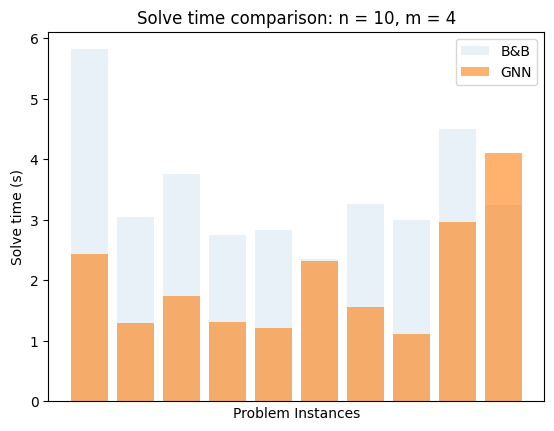

In [156]:
plt.title("Solve time comparison: n = 10, m = 4")
plt.ylabel("Solve time (s)")
plt.xlabel("Problem Instances")
plt.bar(range(test_size), bb_solve11, alpha=0.1, label="B&B")
plt.bar(range(test_size), gnn_solve11, alpha=0.6, label="GNN")
plt.xticks([])
plt.legend()
plt.savefig('n10.png')
plt.show()

Generating data
Training model
Epoch 10/100, Loss: 0.2838892707457909
Epoch 20/100, Loss: 0.28781436727597165
Epoch 30/100, Loss: 0.2834639216844852
Epoch 40/100, Loss: 0.2717553170827719
Epoch 50/100, Loss: 0.26895201893953175
Epoch 60/100, Loss: 0.2738183782650874
Epoch 70/100, Loss: 0.26861159618084246
Epoch 80/100, Loss: 0.26666152477264404
Epoch 90/100, Loss: 0.27653553738043857
Epoch 100/100, Loss: 0.28054807507074797
Training complete!
Starting to solve test problems
BB solved instance in  15.694685935974121  in 86 branches
MIP-GNN solved instance in  13.173373222351074  in 73 branches
BB solved instance in  11.187971830368042  in 62 branches
MIP-GNN solved instance in  6.068428039550781  in 33 branches
BB solved instance in  42.7337121963501  in 228 branches
MIP-GNN solved instance in  10.710847854614258  in 58 branches
BB solved instance in  27.059997081756592  in 141 branches
MIP-GNN solved instance in  7.894930124282837  in 42 branches
BB solved instance in  23.1606230735778

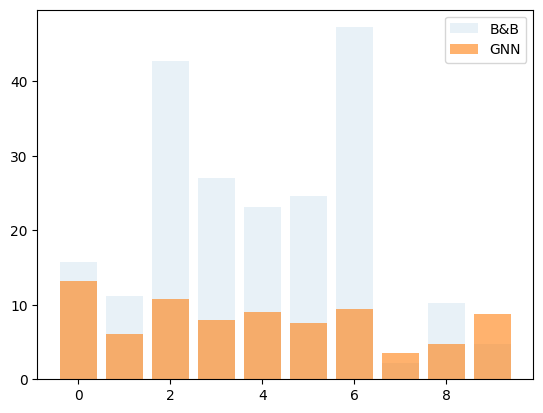

In [157]:
# We see that we get the most gains when B&B takes very long
# Let's try this for larger problem instances
n = 20
m = 4
num_instances, num_epochs, batch_size, test_size = 50, 100, 4, 10
bb_solve12, bb_obj12, bb_branches12, gnn_solve12, gnn_obj12, gnn_branches12, losses12, _ = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

plt.bar(range(test_size), bb_solve12, alpha=0.1, label="B&B")
plt.bar(range(test_size), gnn_solve12, alpha=0.6, label="GNN")
plt.legend()
plt.show()

Generating data
Training model
Epoch 10/100, Loss: 0.3121611304008044
Epoch 20/100, Loss: 0.2861621930049016
Epoch 30/100, Loss: 0.2770453359072025
Epoch 40/100, Loss: 0.2785585018304678
Epoch 50/100, Loss: 0.27566108107566833
Epoch 60/100, Loss: 0.2799542454572824
Epoch 70/100, Loss: 0.28141652735380024
Epoch 80/100, Loss: 0.2844321819452139
Epoch 90/100, Loss: 0.27705297332543594
Epoch 100/100, Loss: 0.2798473078470964
Training complete!
Starting to solve test problems
BB solved instance in  116.40600490570068  in 427 branches
MIP-GNN solved instance in  12.707191705703735  in 49 branches
BB solved instance in  62.01148295402527  in 238 branches
MIP-GNN solved instance in  10.045132637023926  in 39 branches
BB solved instance in  134.40240287780762  in 499 branches
MIP-GNN solved instance in  11.745728969573975  in 45 branches
BB solved instance in  97.81111598014832  in 361 branches
MIP-GNN solved instance in  16.1617488861084  in 62 branches
BB solved instance in  32.69238781929016

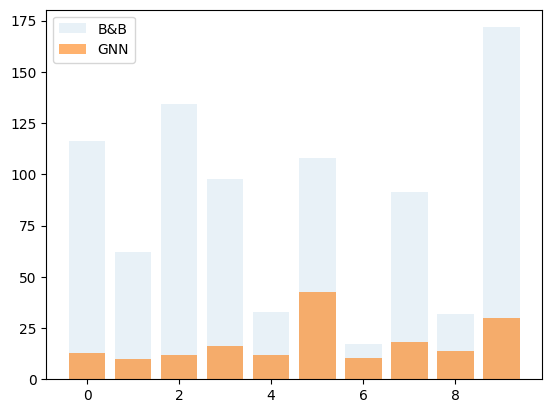

In [158]:
n = 30
m = 4
num_instances, num_epochs, batch_size, test_size = 50, 100, 4, 10
bb_solve13, bb_obj13, bb_branches13, gnn_solve13, gnn_obj13, gnn_branches13, losses13, _ = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

plt.bar(range(test_size), bb_solve13, alpha=0.1, label="B&B")
plt.bar(range(test_size), gnn_solve13, alpha=0.6, label="GNN")
plt.legend()
plt.show()

Generating data
Training model
Epoch 10/500, Loss: 0.24772391296350038
Epoch 20/500, Loss: 0.24614455837469834
Epoch 30/500, Loss: 0.24356233385893014
Epoch 40/500, Loss: 0.24243471599542177
Epoch 50/500, Loss: 0.2437047946911592
Epoch 60/500, Loss: 0.24150163164505592
Epoch 70/500, Loss: 0.24089070581472838
Epoch 80/500, Loss: 0.23488581409821144
Epoch 90/500, Loss: 0.24037373065948486
Epoch 100/500, Loss: 0.258536784694745
Epoch 110/500, Loss: 0.2428538306401326
Epoch 120/500, Loss: 0.23797285900666162
Epoch 130/500, Loss: 0.2417836877015921
Epoch 140/500, Loss: 0.2411796634013836
Epoch 150/500, Loss: 0.2383996878678982
Epoch 160/500, Loss: 0.24095009496578804
Epoch 170/500, Loss: 0.23969242091362292
Epoch 180/500, Loss: 0.2366094061961541
Epoch 190/500, Loss: 0.24103636008042556
Epoch 200/500, Loss: 0.23837496569523445
Epoch 210/500, Loss: 0.2357535843665783
Epoch 220/500, Loss: 0.23835532481853777
Epoch 230/500, Loss: 0.23561493364664224
Epoch 240/500, Loss: 0.23811578521361718
Epo

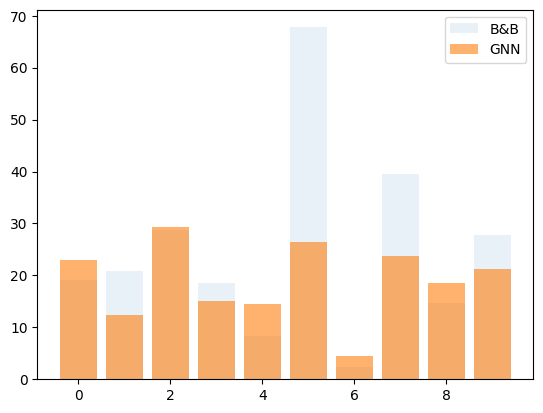

In [161]:
n = 10
m = 6
num_instances, num_epochs, batch_size, test_size = 50, 500, 4, 10
bb_solve21, bb_obj21, bb_branches21, gnn_solve21, gnn_obj21, gnn_branches21, losses21, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

plt.bar(range(test_size), bb_solve21, alpha=0.1, label="B&B")
plt.bar(range(test_size), gnn_solve21, alpha=0.6, label="GNN")
plt.legend()
plt.show()

Generating data
Training model
Epoch 10/500, Loss: 0.2777032657311513
Epoch 20/500, Loss: 0.2451061583482302
Epoch 30/500, Loss: 0.2422515979179969
Epoch 40/500, Loss: 0.24130322726873252
Epoch 50/500, Loss: 0.2418909496985949
Epoch 60/500, Loss: 0.23877157614781305
Epoch 70/500, Loss: 0.2421293304516719
Epoch 80/500, Loss: 0.23806103490866148
Epoch 90/500, Loss: 0.2398438843396994
Epoch 100/500, Loss: 0.23931617117845094
Epoch 110/500, Loss: 0.23907228272694808
Epoch 120/500, Loss: 0.23906608384389144
Epoch 130/500, Loss: 0.23902278680067796
Epoch 140/500, Loss: 0.24077318952633783
Epoch 150/500, Loss: 0.2431419170819796
Epoch 160/500, Loss: 0.2417727640041938
Epoch 170/500, Loss: 0.24066418409347534
Epoch 180/500, Loss: 0.24167717764010796
Epoch 190/500, Loss: 0.24068389374476212
Epoch 200/500, Loss: 0.24054811321772063
Epoch 210/500, Loss: 0.23885827683485472
Epoch 220/500, Loss: 0.23707910455190218
Epoch 230/500, Loss: 0.24141191060726458
Epoch 240/500, Loss: 0.24041695090440604
Ep

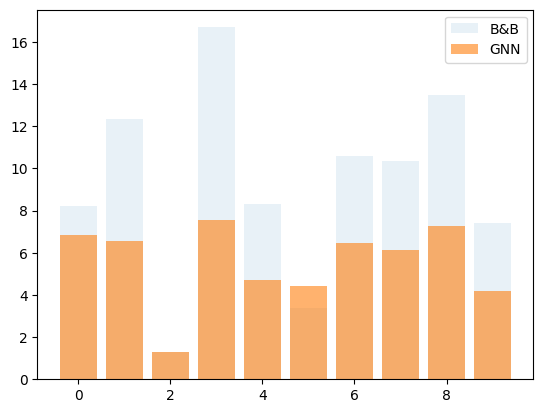

In [169]:
n = 10
m = 5
num_instances, num_epochs, batch_size, test_size = 50, 500, 4, 10
bb_solve31, bb_obj31, bb_branches31, gnn_solve31, gnn_obj31, gnn_branches31, losses31, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

plt.bar(range(test_size), bb_solve31, alpha=0.1, label="B&B")
plt.bar(range(test_size), gnn_solve31, alpha=0.6, label="GNN")
plt.legend()
plt.show()

Generating data
Training model
Epoch 10/500, Loss: 0.2811796080607634
Epoch 20/500, Loss: 0.2717142334351173
Epoch 30/500, Loss: 0.2735161873010489
Epoch 40/500, Loss: 0.2702969037569486
Epoch 50/500, Loss: 0.27221598762732285
Epoch 60/500, Loss: 0.270577602661573
Epoch 70/500, Loss: 0.2716775880410121
Epoch 80/500, Loss: 0.26931692545230573
Epoch 90/500, Loss: 0.2732314673753885
Epoch 100/500, Loss: 0.2744740889622615
Epoch 110/500, Loss: 0.2644620331434103
Epoch 120/500, Loss: 0.26876317193874943
Epoch 130/500, Loss: 0.26778406019394213
Epoch 140/500, Loss: 0.2693146765232086
Epoch 150/500, Loss: 0.26658074213908267
Epoch 160/500, Loss: 0.27101487952929276
Epoch 170/500, Loss: 0.269935096685703
Epoch 180/500, Loss: 0.26677067233965945
Epoch 190/500, Loss: 0.26592600689484525
Epoch 200/500, Loss: 0.26337935947454894
Epoch 210/500, Loss: 0.2623802721500397
Epoch 220/500, Loss: 0.2610221149829718
Epoch 230/500, Loss: 0.26100227580620694
Epoch 240/500, Loss: 0.2637322166791329
Epoch 250/

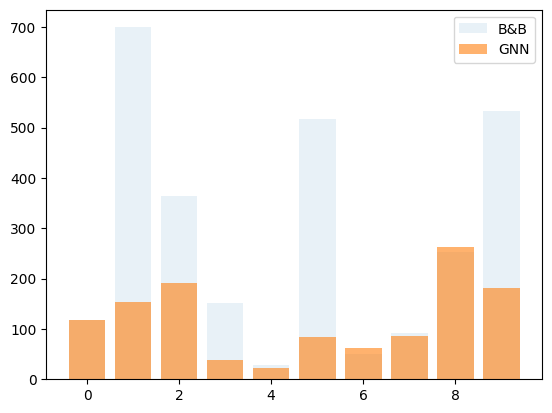

In [125]:
n = 20
m = 6
num_instances, num_epochs, batch_size, test_size = 50, 500, 4, 10
bb_solve22, bb_obj22, bb_branches22, gnn_solve22, gnn_obj22, gnn_branches22, losses22, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

plt.bar(range(test_size), bb_solve22, alpha=0.1, label="B&B")
plt.bar(range(test_size), gnn_solve22, alpha=0.6, label="GNN")
plt.legend()
plt.show()

Generating data
Training model
Epoch 10/500, Loss: 0.3434148018176739
Epoch 20/500, Loss: 0.30874723539902615
Epoch 30/500, Loss: 0.2994921115728525
Epoch 40/500, Loss: 0.2967306971549988
Epoch 50/500, Loss: 0.301733421591612
Epoch 60/500, Loss: 0.297867089509964
Epoch 70/500, Loss: 0.3035791115118907
Epoch 80/500, Loss: 0.3012908720053159
Epoch 90/500, Loss: 0.2987034229131845
Epoch 100/500, Loss: 0.3012712276898898
Epoch 110/500, Loss: 0.3041512232560378
Epoch 120/500, Loss: 0.2967819789281258
Epoch 130/500, Loss: 0.29724185397991765
Epoch 140/500, Loss: 0.3014036932816872
Epoch 150/500, Loss: 0.3037506685807155
Epoch 160/500, Loss: 0.299147550876324
Epoch 170/500, Loss: 0.30397877326378453
Epoch 180/500, Loss: 0.2990245715929912
Epoch 190/500, Loss: 0.30320758200608766
Epoch 200/500, Loss: 0.2977064045575949
Epoch 210/500, Loss: 0.2992649983901244
Epoch 220/500, Loss: 0.3001946061849594
Epoch 230/500, Loss: 0.29594221596534437
Epoch 240/500, Loss: 0.2945415320304724
Epoch 250/500, L

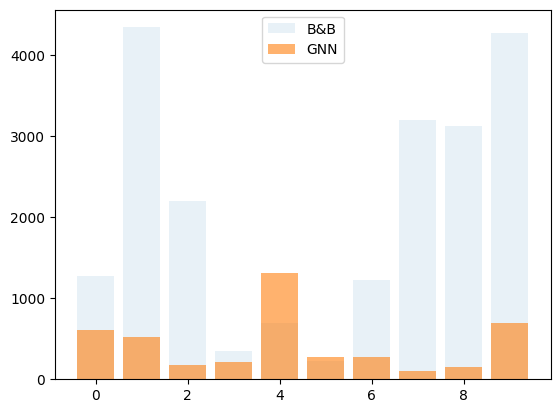

In [126]:
n = 30
m = 6
num_instances, num_epochs, batch_size, test_size = 50, 500, 4, 10
bb_solve23, bb_obj23, bb_branches23, gnn_solve23, gnn_obj23, gnn_branches23, losses23, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

plt.bar(range(test_size), bb_solve23, alpha=0.1, label="B&B")
plt.bar(range(test_size), gnn_solve23, alpha=0.6, label="GNN")
plt.legend()
plt.show()

Generating data
Training model
Epoch 10/500, Loss: 0.32744595866936904
Epoch 20/500, Loss: 0.2892411947250366
Epoch 30/500, Loss: 0.287586958362506
Epoch 40/500, Loss: 0.28533906776171464
Epoch 50/500, Loss: 0.2830986071091432
Epoch 60/500, Loss: 0.2840792892070917
Epoch 70/500, Loss: 0.28089801852519697
Epoch 80/500, Loss: 0.28244824478259456
Epoch 90/500, Loss: 0.2836532352062372
Epoch 100/500, Loss: 0.2833447949244426
Epoch 110/500, Loss: 0.2829036150987332
Epoch 120/500, Loss: 0.28282258946162003
Epoch 130/500, Loss: 0.2839241876051976
Epoch 140/500, Loss: 0.2839055989797299
Epoch 150/500, Loss: 0.284144795857943
Epoch 160/500, Loss: 0.2793888541368338
Epoch 170/500, Loss: 0.2816725717141078
Epoch 180/500, Loss: 0.2851807578251912
Epoch 190/500, Loss: 0.28381599944371444
Epoch 200/500, Loss: 0.2836158550702609
Epoch 210/500, Loss: 0.28602429078175473
Epoch 220/500, Loss: 0.28387730282086593
Epoch 230/500, Loss: 0.28444659136808836
Epoch 240/500, Loss: 0.2826217940220466
Epoch 250/5

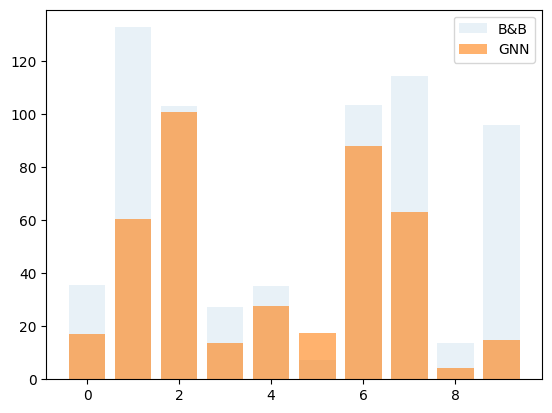

In [170]:
n = 20
m = 5
num_instances, num_epochs, batch_size, test_size = 50, 500, 4, 10
bb_solve32, bb_obj32, bb_branches32, gnn_solve32, gnn_obj32, gnn_branches32, losses32, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

plt.bar(range(test_size), bb_solve32, alpha=0.1, label="B&B")
plt.bar(range(test_size), gnn_solve32, alpha=0.6, label="GNN")
plt.legend()
plt.show()

Generating data
Training model
Epoch 10/500, Loss: 0.34324687260847825
Epoch 20/500, Loss: 0.30766567014730895
Epoch 30/500, Loss: 0.31171199220877427
Epoch 40/500, Loss: 0.3018650389634646
Epoch 50/500, Loss: 0.3123469318334873
Epoch 60/500, Loss: 0.3106645139364096
Epoch 70/500, Loss: 0.3027245241862077
Epoch 80/500, Loss: 0.31180304059615505
Epoch 90/500, Loss: 0.3080669309084232
Epoch 100/500, Loss: 0.307123689697339
Epoch 110/500, Loss: 0.3023577733681752
Epoch 120/500, Loss: 0.3082171965103883
Epoch 130/500, Loss: 0.30384458486850446
Epoch 140/500, Loss: 0.30215391172812534
Epoch 150/500, Loss: 0.3060150547669484
Epoch 160/500, Loss: 0.305511943422831
Epoch 170/500, Loss: 0.3103838345179191
Epoch 180/500, Loss: 0.302140637085988
Epoch 190/500, Loss: 0.30790818425325245
Epoch 200/500, Loss: 0.3024774423012367
Epoch 210/500, Loss: 0.3068186422953239
Epoch 220/500, Loss: 0.3113138366204042
Epoch 230/500, Loss: 0.30423159094957203
Epoch 240/500, Loss: 0.31151814414904666
Epoch 250/50

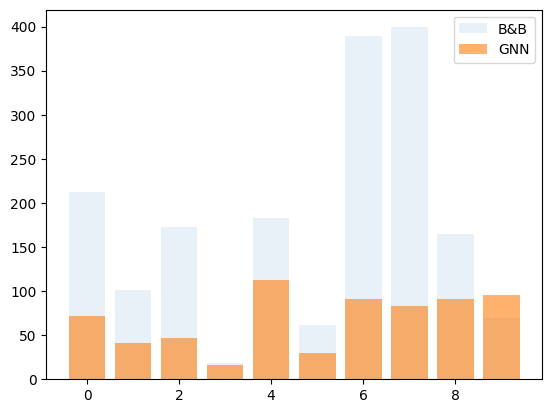

In [171]:
n = 30
m = 5
num_instances, num_epochs, batch_size, test_size = 50, 500, 4, 10
bb_solve33, bb_obj33, bb_branches33, gnn_solve33, gnn_obj33, gnn_branches33, losses33, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

plt.bar(range(test_size), bb_solve33, alpha=0.1, label="B&B")
plt.bar(range(test_size), gnn_solve33, alpha=0.6, label="GNN")
plt.legend()
plt.show()

In [177]:
n = 10
m = 3
num_instances, num_epochs, batch_size, test_size = 50, 100, 4, 10
bb_solve41, bb_obj41, bb_branches41, gnn_solve41, gnn_obj41, gnn_branches41, losses41, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

n = 20
num_instances, num_epochs, batch_size, test_size = 50, 100, 4, 10
bb_solve42, bb_obj42, bb_branches42, gnn_solve42, gnn_obj42, gnn_branches42, losses42, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)

n = 30
num_instances, num_epochs, batch_size, test_size = 50, 100, 4, 10
bb_solve43, bb_obj43, bb_branches43, gnn_solve43, gnn_obj43, gnn_branches43, losses43, pred = do_experiment(m, n, num_instances, num_epochs, batch_size, test_size)


Generating data
Training model
Epoch 10/100, Loss: 0.27408312261104584
Epoch 20/100, Loss: 0.24885208904743195
Epoch 30/100, Loss: 0.24313495823970208
Epoch 40/100, Loss: 0.24571823156796968
Epoch 50/100, Loss: 0.24496970039147598
Epoch 60/100, Loss: 0.24098664636795336
Epoch 70/100, Loss: 0.2415428706086599
Epoch 80/100, Loss: 0.24259197826568896
Epoch 90/100, Loss: 0.2505595638201787
Epoch 100/100, Loss: 0.23838029286036125
Training complete!
Starting to solve test problems
BB solved instance in  1.8419427871704102  in 21 branches
MIP-GNN solved instance in  1.5042660236358643  in 17 branches
BB solved instance in  0.5815091133117676  in 6 branches
MIP-GNN solved instance in  1.3865971565246582  in 17 branches
BB solved instance in  1.020697832107544  in 11 branches
MIP-GNN solved instance in  0.5719380378723145  in 7 branches
BB solved instance in  1.8899478912353516  in 21 branches
MIP-GNN solved instance in  1.1083381175994873  in 13 branches
BB solved instance in  0.8106958866119

In [179]:
# Summary of the results

total_outperformance = 0
for i in range(10):
    if gnn_solve11[i] < bb_solve11[i]:
        total_outperformance += 1
    if gnn_solve12[i] < bb_solve12[i]:
        total_outperformance += 1
    if gnn_solve13[i] < bb_solve13[i]:
        total_outperformance += 1
    if gnn_solve21[i] < bb_solve21[i]:
        total_outperformance += 1
    if gnn_solve22[i] < bb_solve22[i]:
        total_outperformance += 1
    if gnn_solve23[i] < bb_solve23[i]:
        total_outperformance += 1
    if gnn_solve31[i] < bb_solve31[i]:
        total_outperformance += 1
    if gnn_solve32[i] < bb_solve32[i]:
        total_outperformance += 1
    if gnn_solve33[i] < bb_solve33[i]:
        total_outperformance += 1
    if gnn_solve41[i] < bb_solve41[i]:
        total_outperformance += 1
    if gnn_solve42[i] < bb_solve42[i]:
        total_outperformance += 1
    if gnn_solve43[i] < bb_solve43[i]:
        total_outperformance += 1
ratio = total_outperformance / 120
print("GNN outperformed in ", total_outperformance, "/120 problems, (",ratio*100, "%)")

bb_avg_solve_time11 = np.mean(bb_solve11)
gnn_avg_solve_time11 = np.mean(gnn_solve11)
test11 = np.abs((gnn_avg_solve_time11 - bb_avg_solve_time11) / bb_avg_solve_time11)
print("m, n = 4, 10")
print("BB: ", bb_avg_solve_time11)
print("GNN: ", gnn_avg_solve_time11)

bb_avg_solve_time12 = np.mean(bb_solve12)
gnn_avg_solve_time12 = np.mean(gnn_solve12)
test12 = np.abs((gnn_avg_solve_time12 - bb_avg_solve_time12) / bb_avg_solve_time12)
print("m, n = 4, 20")
print("BB: ", bb_avg_solve_time12)
print("GNN: ", gnn_avg_solve_time12)

bb_avg_solve_time13 = np.mean(bb_solve13)
gnn_avg_solve_time13 = np.mean(gnn_solve13)
test13 = np.abs((gnn_avg_solve_time13 - bb_avg_solve_time13) / bb_avg_solve_time13)
print("m, n = 4, 30")
print("BB: ", bb_avg_solve_time13)
print("GNN: ", gnn_avg_solve_time13)

print("m = 4, n = 10: ", test11*100, "% improvement")
print("m = 4, n = 20: ", test12*100, "% improvement")
print("m = 4, n = 30: ", test13*100, "% improvement")

GNN outperformed in  99 /120 problems, ( 82.5 %)
m, n = 4, 10
BB:  3.4547906637191774
GNN:  2.0063467025756836
m, n = 4, 20
BB:  20.87450466156006
GNN:  8.088757085800172
m, n = 4, 30
BB:  86.34334740638732
GNN:  17.73879916667938
m = 4, n = 10:  41.92566502956228 % improvement
m = 4, n = 20:  61.25054358441645 % improvement
m = 4, n = 30:  79.45551139778124 % improvement


In [166]:
bb_avg_solve_time21 = np.mean(bb_solve21)
gnn_avg_solve_time21 = np.mean(gnn_solve21)
test21 = np.abs((gnn_avg_solve_time21 - bb_avg_solve_time21) / bb_avg_solve_time21)
print("m, n = 6, 10")
print("BB: ", bb_avg_solve_time21)
print("GNN: ", gnn_avg_solve_time21)

bb_avg_solve_time22 = np.mean(bb_solve22)
gnn_avg_solve_time22 = np.mean(gnn_solve22)
test22 = np.abs((gnn_avg_solve_time22 - bb_avg_solve_time22) / bb_avg_solve_time22)
print("m, n = 6, 20")
print("BB: ", bb_avg_solve_time22)
print("GNN: ", gnn_avg_solve_time22)

bb_avg_solve_time23 = np.mean(bb_solve23)
gnn_avg_solve_time23 = np.mean(gnn_solve23)
test23 = np.abs((gnn_avg_solve_time23 - bb_avg_solve_time23) / bb_avg_solve_time23)
print("m, n = 6, 30")
print("BB: ", bb_avg_solve_time23)
print("GNN: ", gnn_avg_solve_time23)

print("m = 6, n = 10: ", test21*100, "% improvement")
print("m = 6, n = 20: ", test22*100, "% improvement")
print("m = 6, n = 30: ", test23*100, "% improvement")

m, n = 6, 10
BB:  24.760194373130798
GNN:  18.860165405273438
m, n = 6, 20
BB:  280.47884209156035
GNN:  119.71196312904358
m, n = 6, 30
BB:  2093.94573161602
GNN:  433.39708921909335
m = 6, n = 10:  23.828685990688093 % improvement
m = 6, n = 20:  57.31871886081002 % improvement
m = 6, n = 30:  79.30237242181938 % improvement


In [175]:
bb_avg_solve_time31 = np.mean(bb_solve31)
gnn_avg_solve_time31 = np.mean(gnn_solve31)
test31 = np.abs((gnn_avg_solve_time31 - bb_avg_solve_time31) / bb_avg_solve_time31)
print("m, n = 5, 10")
print("BB: ", bb_avg_solve_time31)
print("GNN: ", gnn_avg_solve_time31)

bb_avg_solve_time32 = np.mean(bb_solve32)
gnn_avg_solve_time32 = np.mean(gnn_solve32)
test32 = np.abs((gnn_avg_solve_time32 - bb_avg_solve_time32) / bb_avg_solve_time32)
print("m, n = 5, 20")
print("BB: ", bb_avg_solve_time32)
print("GNN: ", gnn_avg_solve_time32)

bb_avg_solve_time33 = np.mean(bb_solve33)
gnn_avg_solve_time33 = np.mean(gnn_solve33)
test33 = np.abs((gnn_avg_solve_time33 - bb_avg_solve_time33) / bb_avg_solve_time33)
print("m, n = 5, 30")
print("BB: ", bb_avg_solve_time33)
print("GNN: ", gnn_avg_solve_time33)

print("m = 5, n = 10: ", test31*100, "% improvement")
print("m = 5, n = 20: ", test32*100, "% improvement")
print("m = 5, n = 30: ", test33*100, "% improvement")

m, n = 5, 10
BB:  9.210319900512696
GNN:  5.547060012817383
m, n = 5, 20
BB:  66.82847952842712
GNN:  40.69993772506714
m, n = 5, 30
BB:  177.15935642719268
GNN:  68.03326671123504
m = 5, n = 10:  39.773427277931965 % improvement
m = 5, n = 20:  39.09791452347135 % improvement
m = 5, n = 30:  61.597700463991735 % improvement


In [181]:
bb_avg_solve_time41 = np.mean(bb_solve41)
gnn_avg_solve_time41 = np.mean(gnn_solve41)
test41 = np.abs((gnn_avg_solve_time41 - bb_avg_solve_time41) / bb_avg_solve_time41)
print("m, n = 3, 10")
print("BB: ", bb_avg_solve_time41)
print("GNN: ", gnn_avg_solve_time41)

bb_avg_solve_time42 = np.mean(bb_solve42)
gnn_avg_solve_time42 = np.mean(gnn_solve42)
test42 = np.abs((gnn_avg_solve_time42 - bb_avg_solve_time42) / bb_avg_solve_time42)
print("m, n = 3, 20")
print("BB: ", bb_avg_solve_time42)
print("GNN: ", gnn_avg_solve_time42)

bb_avg_solve_time43 = np.mean(bb_solve43)
gnn_avg_solve_time43 = np.mean(gnn_solve43)
test43 = np.abs((gnn_avg_solve_time43 - bb_avg_solve_time43) / bb_avg_solve_time43)
print("m, n = 3, 30")
print("BB: ", bb_avg_solve_time43)
print("GNN: ", gnn_avg_solve_time43)

print("m = 5, n = 10: ", test41*100, "% improvement")
print("m = 5, n = 20: ", test42*100, "% improvement")
print("m = 5, n = 30: ", test43*100, "% improvement")

m, n = 3, 10
BB:  1.1322901487350463
GNN:  0.8770040273666382
m, n = 3, 20
BB:  3.985439085960388
GNN:  3.534625840187073
m, n = 3, 30
BB:  9.035703659057617
GNN:  5.559447169303894
m = 5, n = 10:  22.54599862531742 % improvement
m = 5, n = 20:  11.31150761684972 % improvement
m = 5, n = 30:  38.47244908556774 % improvement


In [186]:
bb_avg_solve = []
bb_avg_solve.append(bb_avg_solve_time11)
bb_avg_solve.append(bb_avg_solve_time12)
bb_avg_solve.append(bb_avg_solve_time13)
bb_avg_solve.append(bb_avg_solve_time21)
bb_avg_solve.append(bb_avg_solve_time22)
bb_avg_solve.append(bb_avg_solve_time23)
bb_avg_solve.append(bb_avg_solve_time31)
bb_avg_solve.append(bb_avg_solve_time32)
bb_avg_solve.append(bb_avg_solve_time33)
bb_avg_solve.append(bb_avg_solve_time41)
bb_avg_solve.append(bb_avg_solve_time42)
bb_avg_solve.append(bb_avg_solve_time43)

gnn_avg_solve = []
gnn_avg_solve.append(gnn_avg_solve_time11)
gnn_avg_solve.append(gnn_avg_solve_time12)
gnn_avg_solve.append(gnn_avg_solve_time13)
gnn_avg_solve.append(gnn_avg_solve_time21)
gnn_avg_solve.append(gnn_avg_solve_time22)
gnn_avg_solve.append(gnn_avg_solve_time23)
gnn_avg_solve.append(gnn_avg_solve_time31)
gnn_avg_solve.append(gnn_avg_solve_time32)
gnn_avg_solve.append(gnn_avg_solve_time33)
gnn_avg_solve.append(gnn_avg_solve_time41)
gnn_avg_solve.append(gnn_avg_solve_time42)
gnn_avg_solve.append(gnn_avg_solve_time43)

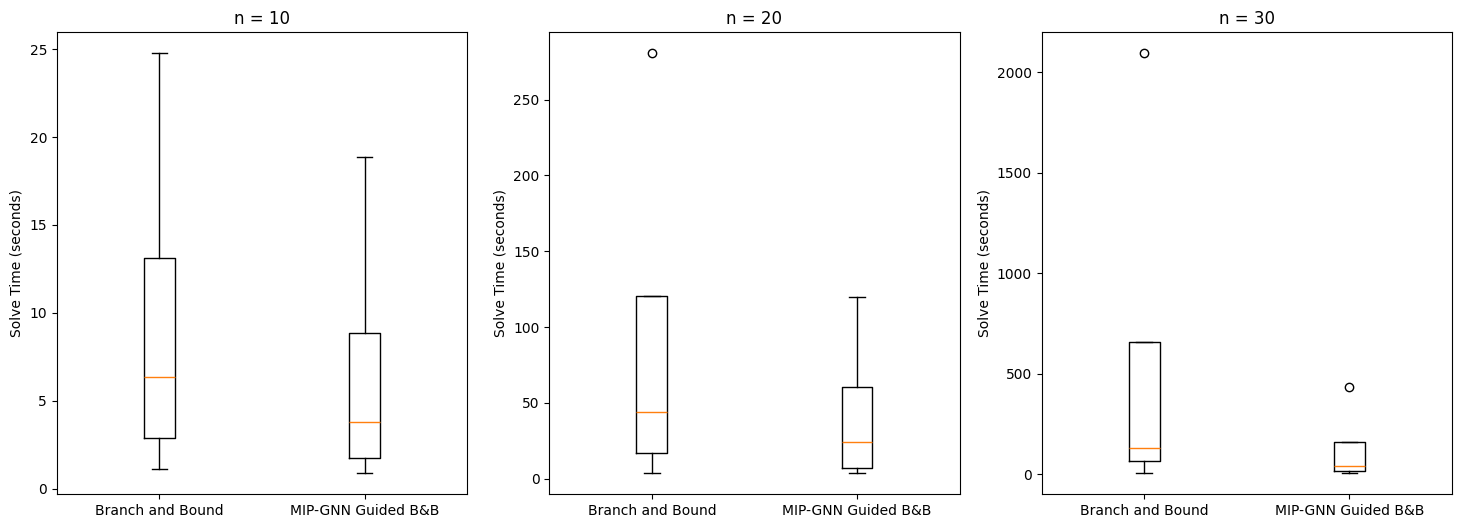

In [198]:
idxs1 = [0, 3, 6, 9]
idxs2 = [1, 4, 7, 10]
idxs3 = [2, 5, 8, 11]

# Get the values for each index set
data1_bb = [bb_avg_solve[i] for i in idxs1]
data1_gnn = [gnn_avg_solve[i] for i in idxs1]

data2_bb = [bb_avg_solve[i] for i in idxs2]
data2_gnn = [gnn_avg_solve[i] for i in idxs2]

data3_bb = [bb_avg_solve[i] for i in idxs3]
data3_gnn = [gnn_avg_solve[i] for i in idxs3]

# Combine data for boxplot
data1 = [data1_bb, data1_gnn]
data2 = [data2_bb, data2_gnn]
data3 = [data3_bb, data3_gnn]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the data
axs[0].boxplot(data1, labels=['Branch and Bound', 'MIP-GNN Guided B&B'])
axs[0].set_ylabel('Solve Time (seconds)')
axs[0].set_title('n = 10')

axs[1].boxplot(data2, labels=['Branch and Bound', 'MIP-GNN Guided B&B'])
axs[1].set_ylabel('Solve Time (seconds)')
axs[1].set_title('n = 20')

axs[2].boxplot(data3, labels=['Branch and Bound', 'MIP-GNN Guided B&B'])
axs[2].set_ylabel('Solve Time (seconds)')
axs[2].set_title('n = 30')

plt.savefig('boxplots.png')
plt.show()

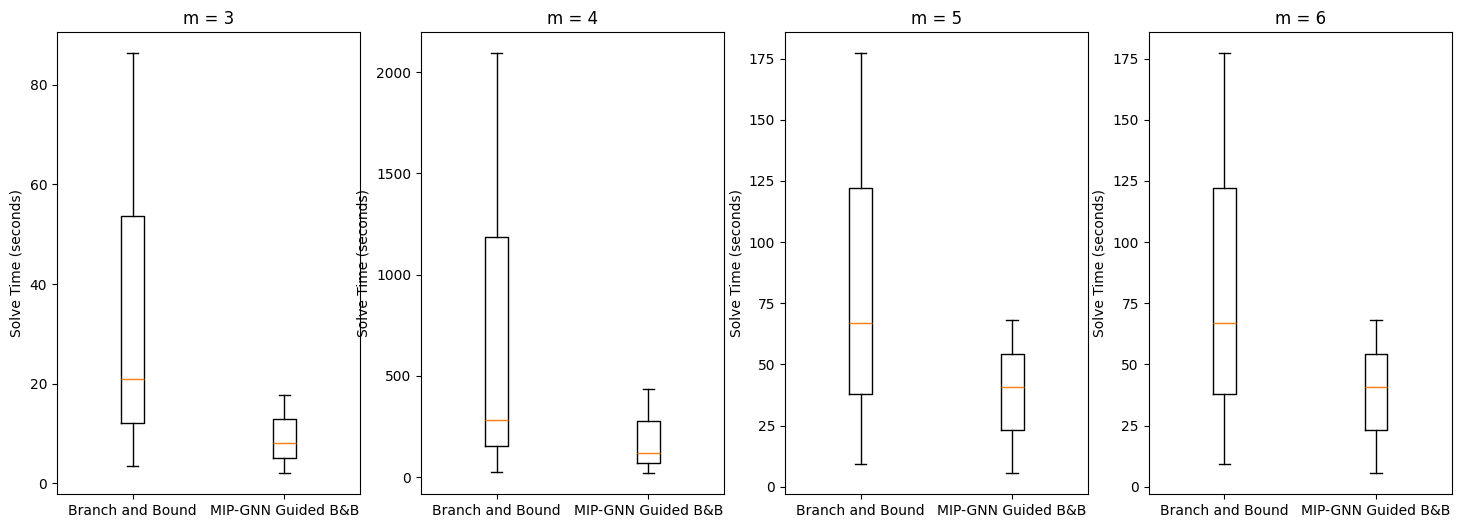

In [201]:
idxs1 = [0, 1, 2]
idxs2 = [3, 4, 5]
idxs3 = [6, 7, 8]
idxs4 = [9, 10, 11]

# Get the values for each index set
data1_bb = [bb_avg_solve[i] for i in idxs1]
data1_gnn = [gnn_avg_solve[i] for i in idxs1]

data2_bb = [bb_avg_solve[i] for i in idxs2]
data2_gnn = [gnn_avg_solve[i] for i in idxs2]

data3_bb = [bb_avg_solve[i] for i in idxs3]
data3_gnn = [gnn_avg_solve[i] for i in idxs3]

data4_bb = [bb_avg_solve[i] for i in idxs4]
data4_gnn = [gnn_avg_solve[i] for i in idxs4]

# Combine data for boxplot
data1 = [data1_bb, data1_gnn]
data2 = [data2_bb, data2_gnn]
data3 = [data3_bb, data3_gnn]
data4 = [data4_bb, data4_gnn]

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(18, 6))

# Plot the data
axs[0].boxplot(data1, labels=['Branch and Bound', 'MIP-GNN Guided B&B'])
axs[0].set_ylabel('Solve Time (seconds)')
axs[0].set_title('m = 3')

axs[1].boxplot(data2, labels=['Branch and Bound', 'MIP-GNN Guided B&B'])
axs[1].set_ylabel('Solve Time (seconds)')
axs[1].set_title('m = 4')

axs[2].boxplot(data3, labels=['Branch and Bound', 'MIP-GNN Guided B&B'])
axs[2].set_ylabel('Solve Time (seconds)')
axs[2].set_title('m = 5')

axs[3].boxplot(data3, labels=['Branch and Bound', 'MIP-GNN Guided B&B'])
axs[3].set_ylabel('Solve Time (seconds)')
axs[3].set_title('m = 6')

plt.savefig('boxplots2.png')
plt.show()